In [1]:
from charloc3 import identify

import numpy as np
import random

import keras
from keras import datasets, layers, models, preprocessing

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from PIL import Image, ImageDraw

import json
import os
import statistics as stats

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) 

In [3]:
counter = 200

In [15]:
# get plate cropping model
json_file = open('model_v3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
crop_plate = models.model_from_json(loaded_model_json)
crop_plate.load_weights("model_v3_3.h5")

# get char detect model
json_file = open('charcollectedvgg.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
char_detect = models.model_from_json(loaded_model_json)
char_detect.load_weights("charcollectedvgg.h5")

# detectplate v1
def detectplate(img_path):
    # prediction of the bounding box
    im = Image.open(img_path)
    im.thumbnail((400, 300))
    ini = np.array([np.asarray(im)]) / 255
    out = crop_plate.predict(ini)[0]

    # coords of bounding box            
    x1, y1, x2, y2 = out[0] * im.size[0], out[1] * im.size[1], out[2] * im.size[0], out[3] * im.size[1] 
    im_h = abs(y1 - y2); im_w = abs(x1 - x2)
    y1 -= im_h; y2 += im_h
    
    padding = 3; xleeway = 5; yleeway = 5
    
    rect = patches.Rectangle((x1 - xleeway, y1 - yleeway), im_w + 2 * xleeway, im_h + 2 * yleeway, linewidth=2, edgecolor='r', fill = False)
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(np.asarray(im))
    ax.add_patch(rect)
    plt.show()
    
#    draw = ImageDraw.Draw(im)
#   draw.rectangle((x1 + padding - xleeway, y1 + padding - yleeway, x1 - padding - xleeway, y1 - padding - yleeway), (244,232,46))
#   draw.rectangle((x2 + padding + xleeway, y2 + padding + yleeway, x2 - padding + xleeway, y2 - padding + yleeway), (244,232,46))
#   plt.figure()
#   plt.imshow(np.asarray(im))

    # cropping image (top left, bottom right)
    cropped = im.crop((x1 - xleeway, y1 - yleeway, x2 + xleeway, y2 + yleeway))

    # convert the cropped plate thingy into a open cv thingy
    open_cv_image = np.array(cropped) 
    # Convert RGB to BGR 
    open_cv_image = open_cv_image[:, :, ::-1].copy()

    # get the box of each char
    lis = identify(open_cv_image)    

    res = ''
    # detect individual char
    idx = 0
    for coord in lis:
        crop_char = cropped.crop((coord[0][0], coord[0][1], coord[1][0], coord[1][1]))
        crop_char = crop_char.resize((20, 30))
        plt.figure()
        plt.imshow(np.asarray(crop_char))
        idx += 1
        # get prediction
        ini = np.array([np.asarray(crop_char)]) / 255
        out = char_detect.predict(ini)[0]
        # identify prediction
        dicta = '0123456789ABCDEFGHJKLMNPQRSTUVWXYZ'
        maxi = 0
        idx = 0
        for i in range(0, len(out)):
            if i == 0:
                maxi = out[i]
            elif(out[i] > maxi):
                maxi = out[i]
                idx = i
        res = res + dicta[idx]
        
    return res

<Figure size 432x288 with 0 Axes>

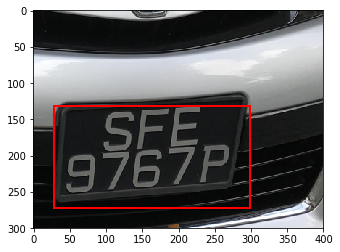

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


'SFE9767P'

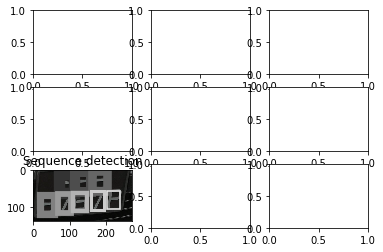

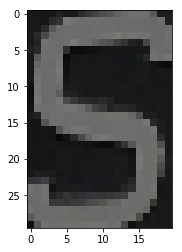

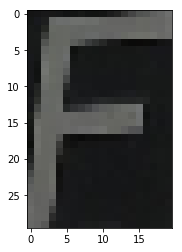

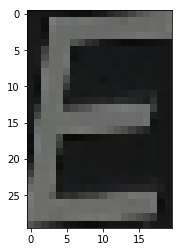

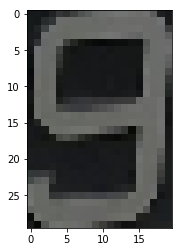

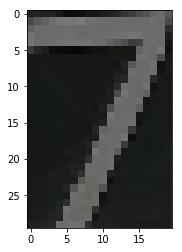

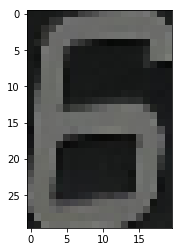

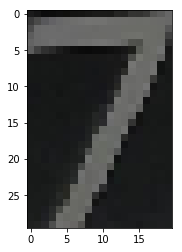

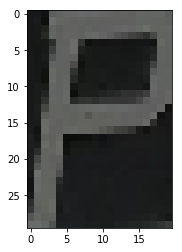

In [16]:
detectplate('plate_data/collected/SFE9767P/2IMG_2719.jpg')

In [121]:
directory = 'data/SML2068A'
imagelist = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
counter = 0

detectplate(directory + '/' + imagelist[0])

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/SML2068A'

In [6]:
eps = 5 # error margin
small = 1e-6
# input is box
def generate_tot_points(unordered_boxes):
    num_char = 0 # denotes number of characters 
    line_type = 0 # number of lines

    x = np.zeros(10)
    y = np.zeros(10)
    boxes = []
    num_box = 0
    for box in unordered_boxes: # for each bounding box
        #print(box)
        x[num_box] = box[0]
        y[num_box] = box[1]
        boxes.append(box)
        num_box += 1
    #print(x)
    #print(y)
    #test_box = []
    #for i in range(0,num_box):
    #	test_box.append((x[i],y[i],i))
    #print_box(img,test_box,boxes)

    # line is in the form ax+by+c=0
    final_a = 0
    final_b = 0
    final_c = 0
    final_points = []

    # first, check if 1 line can fit 7 / 8 boxes
    for i in range(0,num_box):
        for j in range(i+1,num_box):
            x1 = x[i]
            y1 = y[i]
            x2 = x[j]
            y2 = y[j]

            a = (y[i]-y[j])
            b = (x[j]-x[i])
            c = x[i]*y[j] - x[j]*y[i]
            check = 0
            line_points = []

            for k in range(0,num_box):
                diff = (a*x[k] + c)/(b+small)+y[k]
                if (abs(diff) <= eps):
                    check += 1
                    line_points.append((x[k],y[k],boxes[k][2],boxes[k][3],boxes[k][4]))

            if check >= 6: # line misses at most 1 point
                final_a = a
                final_b = b
                final_c = c
                final_points = line_points


    if final_a != 0 or final_b != 0 or final_c != 0:
        line_type = 1
    else:
        line_type = 2

    if line_type == 1:

        final_points.sort()
        return final_points
        #print(sort_box)
    else:
        # from here on, we assume that the first line has 3 characters
        # first line
        line1_a = 0
        line1_b = 0
        line1_c = 0
        line1_points = []

        # second line
        line2_a = 0
        line2_b = 0
        line2_c = 0
        line2_points = []
        num_line2 = 0

        for i in range(0,num_box):
            for j in range(i+1,num_box):
                x1 = x[i]
                y1 = y[i]
                x2 = x[j]
                y2 = y[j]

                a = (y[i]-y[j])
                b = (x[j]-x[i])
                c = x[i]*y[j] - x[j]*y[i]
                check = 0

                line_points = []
                for k in range(0,num_box):
                    diff = (a*x[k] + c)/(b+small)+y[k]
                    if (abs(diff) <= eps): # count number that are close to the line
                        check += 1
                        line_points.append((x[k],y[k],boxes[k][2],boxes[k][3],boxes[k][4]))

                if check == 3: # this is the first line
                    line1_a = a
                    line1_b = b
                    line1_c = c
                    line1_points = line_points

                elif check >= 4 and check <= 5: # this is the second line
                    line2_a = a
                    line2_b = b
                    line2_c = c
                    line2_points = line_points

        line1_points.sort()
        line2_points.sort()
        tot_points = line1_points+line2_points
        return tot_points

In [15]:
'''
# get plate cropping model
json_file = open('model_v2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
crop_plate = models.model_from_json(loaded_model_json)
crop_plate.load_weights("model_v2.h5")

# get char detect model
json_file = open('chardetect.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
char_detect = models.model_from_json(loaded_model_json)
char_detect.load_weights("chardetect.h5")

counter = 200

def detectplate(img_path):
    global counter

    # prediction of the bounding box
    im = Image.open(img_path)
    im.thumbnail((400, 300))
    ini = np.array([np.asarray(im)]) / 255
    out = crop_plate.predict(ini)[0]

#     # draw thingy
#     x1, y1, x2, y2= out[0] * im.size[0], out[1] * im.size[1], out[2] * im.size[0], out[3] * im.size[1] 
#     draw = ImageDraw.Draw(im)
#     padding = 3
#     draw.rectangle((x1 + padding, y1 + padding, x1 - padding, y1 - padding), (244,232,46))
#     draw.rectangle((x2 + padding, y2 + padding, x2 - padding, y2 - padding), (244,232,46))
#     plt.figure()
#     plt.imshow(np.asarray(im))

    # coords of bounding box            
    x1, y1, x2, y2= out[0] * im.size[0], out[1] * im.size[1], out[2] * im.size[0], out[3] * im.size[1] 
    im_h = abs(y1 - y2)
    y1 -= im_h; y2 += im_h

    # cropping image (top left, bottom right)
    cropped = im.crop((x1 - 10, y1 - 10, x2 + 10, y2 + 10))

    # convert the cropped plate thingy into a open cv thingy
    open_cv_image = np.array(cropped) 
    # Convert RGB to BGR 
    open_cv_image = open_cv_image[:, :, ::-1].copy()

    # get the box of each char
    lis = chris.identify(open_cv_image)    
    #print(len(lis))
    # detect individual char
    char_array = []
    for coord in lis:
        # array for current guess which stores coords, char guess, and confidence value
        guess = [] 
        for val in coord:
            for k in val:
                guess.append(k)# top left, btm right
                
        # get crop of char
        crop_char = cropped.crop((coord[0][0], coord[0][1], coord[1][0], coord[1][1]))
        crop_char = crop_char.resize((32, 32))
        
        # get prediction
        ini = np.array([np.asarray(crop_char)]) / 255
        out = char_detect.predict(ini)[0]
        # identify prediction
        dicta = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
        maxi = 0
        idx = 0
        for i in range(0, len(out)):
            if i == 0:
                maxi = out[i]
            elif(out[i] > maxi):
                maxi = out[i]
                idx = i
        #print(out)
        guess.append(dicta[idx]); guess.append(maxi)
        # append the guess into the char_array, which maintains all the guesses of the model
        char_array.append(guess)
    # sort by confidence value..
    char_array.sort(key = lambda val: val[-1], reverse = True)
    # ..and choose best eight
    char_array = char_array[:8]
    print(char_array)
    final_guess = generate_tot_points([val[:5] for val in char_array])
    #print(final_guess)
    res = ''
    for i in final_guess:
        res = res + i[-1]
        
    # adding some stuff to add data and stuff
#     plate = img_path.split('/')[1]
#     if(plate == res):
#         if(not os.path.isdir('cropped/' + plate)):
#             os.mkdir('cropped/' + plate)
#         cropped.save('cropped/'  + plate + '/' + img_path.split('/')[2] + '_cr.jpg')

#         for i in len(char_array):
#             char_array[i].save('cropped/extracted_char/' + plate[i] + '/' + str(counter) + '.jpg')
#             counter += 1 
    return res
'''

[[44, 8, 69, 39, 'S', 0.99995935], [106, 56, 129, 85, '7', 0.99995387], [47, 35, 70, 63, '7', 0.99979001], [0, 42, 135, 106, 'K', 0.99956447], [46, 0, 183, 63, '1', 0.99889767], [74, 17, 98, 45, 'F', 0.99764329], [139, 68, 163, 95, 'P', 0.99753845], [105, 28, 131, 64, 'E', 0.99591523]]


'SFE'

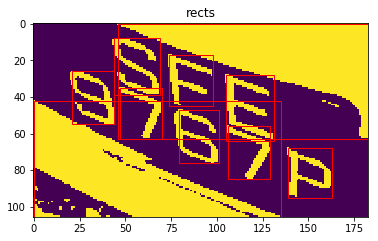

In [16]:
directory = 'data/SFE9767P'
imagelist = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
counter = 0
detectplate(directory + '/' + imagelist[7])

In [10]:
print(counter / len(imagelist))

0.47134713471347134


In [25]:
new = ['SFA5335A,SFC6996A,SGJ8909R,SGW7909D,SJB2822C,SJG2436H,SKA6503R,SKH424M,SKP416U,,SKQ6010L,SKR8139G,SLB5490H,SLC9071C,SLD7956H,SLM3970U,SLQ1670C,SLS2928T,SLT4252R,SML2068A']
new = new[0].split(',')
for st in os.listdir('data'):
    if st in new:
        for name in os.listdir('data/' + st):
            detectplate('data/' + st + '/' + name)
            


SFA5335A K5S53S1
SFA5335A 
SFA5335A 5315351
SFA5335A V5SV335
SFA5335A 63A63SP
SFC6996A SF0699A
SFC6996A SFDPPPFA
SFC6996A SFG691
SGJ8909R GJ8909P
SGJ8909R 
SGJ8909R SG38909P
SGJ8909R SJ8909K
SGJ8909R SSJ8909K
SGJ8909R 
SGJ8909R GJ89D9P
SGW7909D AW79Y9D
SGW7909D W79D9D
SGW7909D 6W79D9D
SGW7909D S6W79D9D
SGW7909D P9141W4
SJB2822C 
SJB2822C K92
SJB2822C 
SJB2822C 1VK
SJB2822C SSS
SJB2822C KS1
SJB2822C S14
SJB2822C 
SJB2822C 11S11V4
SJG2436H SJEK41
SJG2436H KW1KW12
SJG2436H VG2436K
SKA6503R SK16503P
SKA6503R SKA6SD3
SKA6503R SKA65D3K
SKA6503R SKA65D3K
SKH424M 
SKH424M 
SKH424M 
SKH424M SKP424
SKH424M SK1SKP2V
SKH424M JV2U174V
SKP416U KP46U4
SKP416U ASKP46U
SKP416U JSKP46U
SKP416U SKP46U
SKP416U SKP41EU
SKQ6010L SKJ8JDL1
SKQ6010L SKJ6DDL
SKQ6010L SKJ6J0L
SKQ6010L SKJ6D0L
SKQ6010L SKD8J0L
SKQ6010L SKJ600L
SKQ6010L SKJ600L
SKQ6010L SKJ600L
SKQ6010L SKD6JJL
SKR8139G WSKP84G
SKR8139G SKK839G
SKR8139G SKP8139G
SKR8139G WKK39G
SKR8139G KP439G1
SKR8139G WSKK839G
SLB5490H WW4WWS4W
SLB5490H SL8649D8